# EGD103 Assignment 1: Truss Design

Simulation is a powerful tool in structural design, allowing for many different load cases and design options to be evaluated rapidly. In this assignment, you will be simulating trusses, which are a type of structure commonly seen in bridges such as Brisbane's Story bridge.

The process used to simulate trusses is Finite Element Analysis (FEA). Programming this solution process ourselves is outside the scope of this subject, so we will use a Python module called anaStruct to perform the FEA solution method for us. You will still need to create some of your own functions though - while FEA can return member forces and node displacements, it can not determine whether a particular truss design can safely support the loads applied to it. 

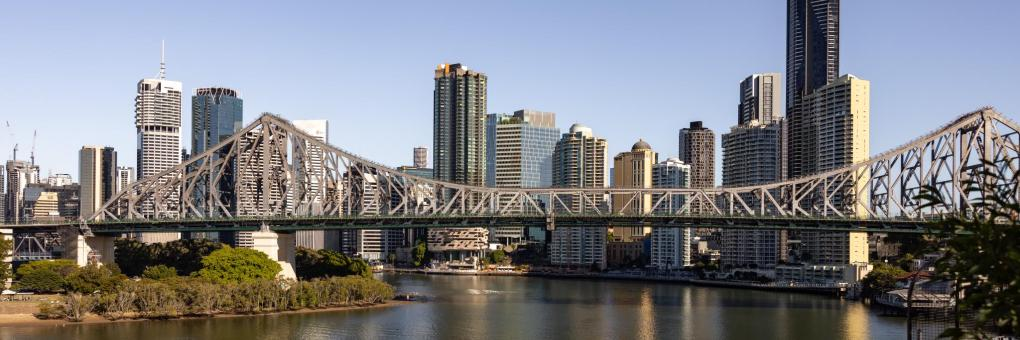
<p style="text-align: center;">Truss design of Brisbane's Story Bridge. Source: booking.com</p>

**The modules below are the only ones you may import for this assignment.**

In [1]:
# Always execute this code first before trying to execute any of the code cells below
import anastruct
import math

**Global properties of the trusses are defined below. Do not change.**

In [2]:
# Note: everything is in SI units

# properties of steel
elastic_modulus = 200e9
yield_stress = 250e6

# member geometry - 20cm side length squares
area = 0.04
inertia = 1.33e-4
weight_per_metre = 3e4

# deflection limit
deflection_limit = 0.01

___
## Part 1: Introduction to anaStruct

Below is an example of the creation of an truss model using anaStruct. You should read and run the cells in section 1.1, and then answer the questions about the model creation and solving process in section 1.2. 

You can consult anaStruct's documentation for if you require more information about any of its capabilities: https://anastruct.readthedocs.io/en/latest/index.html.

### 1.1 An anaStruct example model

#### Phase 1: Geometry and member properties
The preprocessing phase involves creating the geometry of the truss, as well as defining the required member properties. Truss geometry consists of nodes, which act as pin joints, and elements which model the truss members. The results can then be visualised to check that the geometry looks correct. Below is an implementation for a simple example truss.

In [3]:
# This code has been provided for you - do not change it!
def create_truss(display = False):
    
    # create new truss model and define material stiffness properties
    truss = anastruct.SystemElements(EA = elastic_modulus * area, EI = elastic_modulus * inertia)
    
    # Defining truss nodes (ie. joints)
    # top joints
    t1 = (3, 3)
    t2 = (6, 3)
    t3 = (9, 3)
    
    # bottom joints
    b1 = (0, 0)
    b2 = (3, 0)
    b3 = (6, 0)
    b4 = (9, 0)
    b5 = (12, 0)
    
    # Creating truss elements (ie. members)
    # top members
    truss.add_truss_element([t1, t2])
    truss.add_truss_element([t2, t3])
    
    # bottom members
    truss.add_truss_element([b1, b2])
    truss.add_truss_element([b2, b3])
    truss.add_truss_element([b3, b4])
    truss.add_truss_element([b4, b5])
    
    # verticals
    truss.add_truss_element([b2, t1])
    truss.add_truss_element([b3, t2])
    truss.add_truss_element([b4, t3])
    
    # diagonals
    truss.add_truss_element([b1, t1])
    truss.add_truss_element([b2, t2])
    truss.add_truss_element([b4, t2])
    truss.add_truss_element([b5, t3])

    # displaying geometry to check for correctness
    if display == True:
        truss.show_structure()
    
    return truss
    

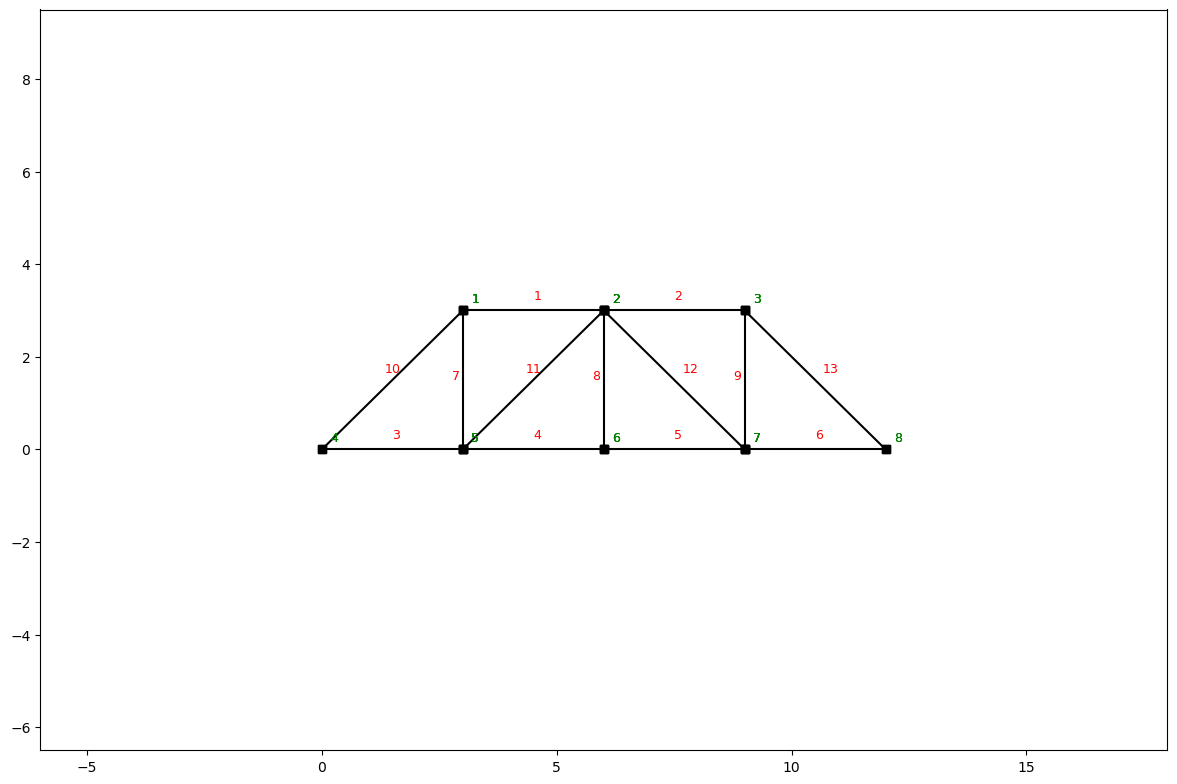

In [4]:

# Calling function and visually checking for correctness
import anastruct
example_truss_geometry = create_truss(display = True)

#### Phase 2: Loads and supports
This phase consists of adding loads and supports to the model and then solving. In this case, the truss will be supported at each end via a pin support. For loading, we consider an applied downward force applied to the middle of the truss, as well as the self-weight of the truss members.

In [5]:
# This code has been provided for you - do not change it!
def load_truss(truss, applied_load, display = False):
    
    # add pin-supports to bottom left and right nodes
    truss.add_support_hinged(4)
    truss.add_support_hinged(8)

    # adding an applied load as a downward point force to the centre of the bridge
    truss.point_load(6, Fy = -applied_load)
    
    # adding self weight to all truss members
    for member_id in range(1, truss.id_last_element + 1):
        truss.q_load(-weight_per_metre, member_id, direction = 'y')
    
    # display structure to check if loads and supports are correct
    if display == True:
        truss.show_structure()
    
    return truss

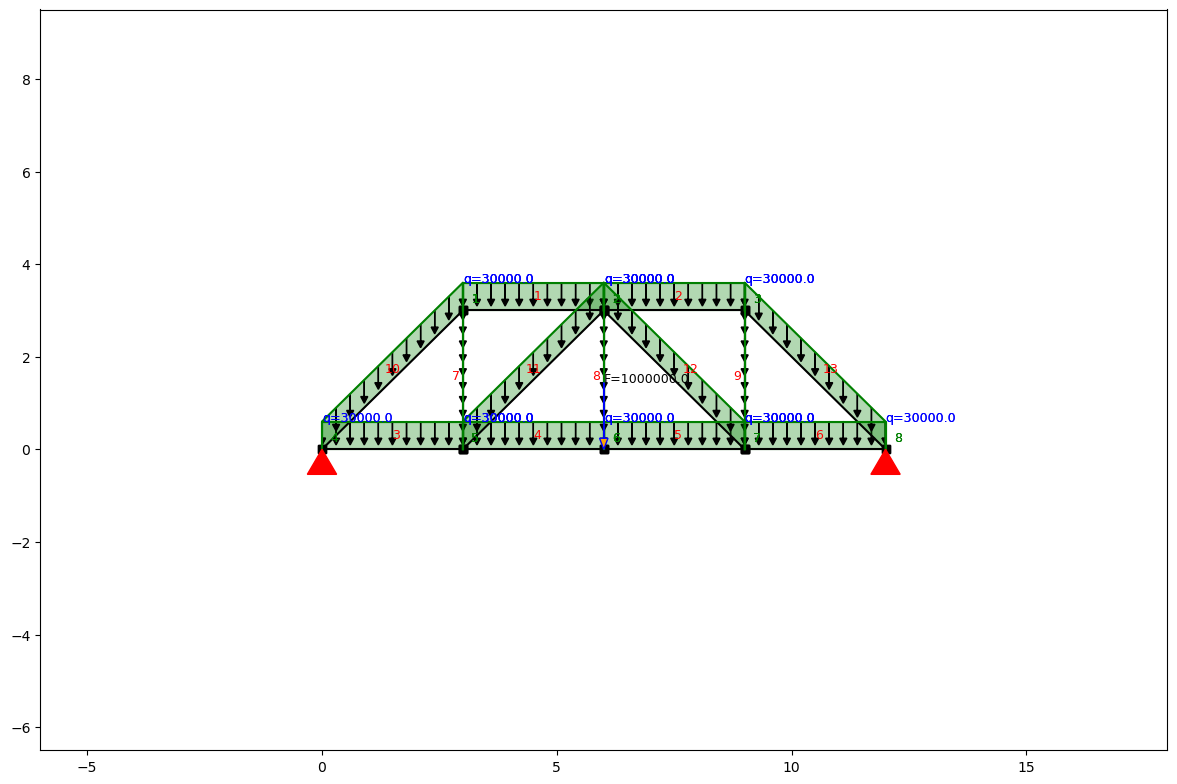

In [6]:
# Calling function and visually checking for correctness
example_truss_loaded = load_truss(example_truss_geometry, 1e6, display = True)

#### Phase 3: Solving and Post Processing
Here the model is solved, and the output information of interest is returned. The outputs are:
* The force applied to each member. A positive force indicates tension, while a negative indicates compression.
* The length of each member. This is critical to determine whether compressive members will buckle.
* Vertical displacements of each joint. Positive indicates upward displacement, and negative indicates downward displacement.

In [7]:
# This code has been provided for you - do not change it!
def solve_truss(truss, display = False):
    
    # solve truss model
    truss.solve()

    # joint displacements
    vertical_joint_displacements = truss.get_node_result_range('uy')
    
    # member properties
    member_forces = []
    member_lengths = []
    for member_id in truss.element_map.keys():
        member_forces.append(round(truss.get_element_results(member_id)['Nmax']))
        member_lengths.append(truss.get_element_results(member_id)['length'])
    
    # code to display results if display argument is set to True
    if display == True:
        print('Member forces:')
        print(member_forces, '\n')
        
        print('Member lengths:')
        print(member_lengths, '\n')

        print('Vertical joint displacements:')
        print(vertical_joint_displacements, '\n')
    
    return member_forces, member_lengths, vertical_joint_displacements

In [8]:
# Calling function to solve forces and displacements
member_forces, member_lengths, node_displacements = solve_truss(example_truss_loaded, display = True)

Member forces:
[-1050919, -1050919, -349320, 349320, 349320, -349320, 942279, 1180000, 942279, -1441224, -943026, -943026, -1441224] 

Member lengths:
[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.242640495300293, 4.242640495300293, 4.242640495300293, 4.242640495300293] 

Vertical joint displacements:
[-0.0015087622465368242, -0.0027172560510272613, -0.0015087622465368242, -0.0, -0.0018452419521089519, -0.003142881051027261, -0.0018452419521089523, -0.0] 



### 1.2 Test your understanding
<span style="color:darkred"><b>Task:</b> After running all the code above, answer the following questions in the Markdown cell below:
1. How are the node ids (eg. 1, 2, 3, ...) assigned?
2. How are the member ids (eg. 1, 2, 3, ... ) assigned?
3. How much force is applied to member 5? Is it a tension force or a compression force?
4. What is the displacement of node 3? Is it up or down?
</span>

1. The nodes are assigned using a tupple with the left and right being x and y cordinates
2. A list was created from the tupples to make up the members connecting each nodes
3. Member 5 is in tension (force of 349320N)
4. The displacement for node 3 is down of -0.0015087622465368242


___
## Part 2: Testing for truss failure
You saw in the example above that anastruct can output a list of all the member forces, member lengths and joint displacements. In this section you will create some user-defined functions that look at this information to assess whether the bridge will fail or not.

### 2.1 Tensile failure
If the tensile force applied to a member is too large, it will cause the material to yield, inducing member failure. This failure load can be calculated with the equation: 

$$F_{fail} = \sigma_y \times A$$

where 
* $\sigma_y$ is the yield stress of the material
* $A$ is the cross-sectional area of the material

<span style="color:darkred"><b>Task:</b> In the cell below, create a function which calculates the tensile failure load of a member. No arguments are required since we are using the global variables that were assigned at the beginning of the assignment.</span>

In [9]:
def tensile_failure_load():
    return yield_stress*area

In [10]:
# test case - should return 10000000.0
tensile_failure_load()

10000000.0

### 2.2 Compressive failure
If the compressive force applied to a member is too large, it will cause the member to buckle, inducing truss failure. This failure load can be calculated with the equation: 

$$F_{fail} = -\frac{\pi^2 EI}{L^2}$$

where:
* $E$ is the elastic modulus of the material
* $I$ is the area moment of inertia
* $L$ is the member length

<span style="color:darkred"><b>Task:</b> In the cell below, create a function which calculates the compressive failure load of a member. Since member length can vary throughout a truss, it is supplied as an argument for the function. All other values have been stored globally.</span>

In [11]:
def compressive_failure_load(length):
    x =-((math.pi**2*elastic_modulus*inertia)/(length)**2)
    return x

In [12]:
# test case 1 - should return -65632869.267244235
compressive_failure_load(2)

-65632869.267244235

In [13]:
# test case 2 - should return -2625314.770689769
compressive_failure_load(10)

-2625314.770689769

### 2.3 Determining whether deflection limit is exceeded
Another failure mode of a truss is excessive deflection. Usually, standards will provide a certain deflection limit. If this limit is exceeded, then the truss is considered unsuitable as it changes its' shape too much under loading.

<span style="color:darkred"><b>Task:</b> In the cell below, create a function which determines whether the input y-displacement has a magnitude that exceeds the deflection limit. It should return True if it does and False otherwise.</span>

In [14]:
def is_deflection_failure(y_displacement):
    return y_displacement > deflection_limit or y_displacement < -deflection_limit

In [15]:
# test case 1 - should return True
is_deflection_failure(0.02)

True

In [16]:
# test case 2 - should return False
is_deflection_failure(0.01)

False

In [17]:
# test case 3 - should return False
is_deflection_failure(-0.005)

False

In [18]:
# test case 4 - should return True
is_deflection_failure(-0.05)

True

### 2.4 Determining whether member failure occurs
In questions 2.1 and 2.2 we established there are two types of member failure; tensile and compressive. Member failure will occur if the member force is higher than the tensile limit or lower (ie. more negative) than the compressive limit.

<span style="color:darkred"><b>Task:</b> In the cell below, create a function that accepts a member force and a member length as inputs. It should output True if the member fails due excessive tensile or compressive force. Otherwise, it should return False. **Important:** from now on, consider calling functions from earlier in the assignment to solve problems!</span>

In [19]:
def is_member_failure(force, length):
    return tensile_failure_load() < force or compressive_failure_load(length) > force

In [20]:
# test case 1 - should return False
is_member_failure(1e6, 5)

False

In [21]:
# test case 2 - should return True
is_member_failure(2e9, 5)

True

In [22]:
# test case 3 - should return False
is_member_failure(-3e6, 5)

False

In [23]:
# test case 3 - should return True
is_member_failure(-4e8, 5)

True

### 2.5 Testing all members and joints for failure
Now that you have functions that test for deflection failure of a single joint and tensile/compressive failure of a single member, we want you to loop through all the members and all the joints of a truss to see if any failures are observed.

Your function will accept three arguments:
* member_forces, which is a list containing the force of each member
* member_lengths, which is a list containing the length of each member
* node_displacements, which is a list containing the y-displacement of each node

Your function should firstly iterate through each member to test for member failure. If any member failure is found, you should exit the function and return the string 'member failure'.

If no member failure is found, it should then iterate through each node to test for excessive displacement. If any nodes displace too much, you should exit the function and return 'deflection failure'.

If no member or node failures are found, the function should return 'safe'.

<p><span style="color:darkred"><b>Task</b> In the cell below, create the function described above.</span>

# Original code
def is_truss_safe(member_forces, member_lengths, node_displacements):
    for index in range(len(member_forces)):
        forces = member_forces[index]
        for index in range (len(member_lengths)):
            lengths  = member_lengths[index]
            if is_member_failure(forces, lengths):
                return "member failure"
    for index in range(len(node_displacements)):
        y_displacements = node_displacements[index]
        if is_deflection_failure(y_displacements):
            return "deflection failure"
    else:
        return "safe"

In [24]:
#After shortened the code
def is_truss_safe(member_forces, member_lengths, node_displacements):
    for index in range(len(member_forces)):
        if is_member_failure(member_forces[index],member_lengths[index]):
            return "member failure"
    for index in range(len(node_displacements)):
        if is_deflection_failure(node_displacements[index]):
            return "deflection failure"
    return "safe"

In [25]:
# test case 1 - let's test out the example truss from part 1
# should return 'safe'
forces, lengths, y_displacements = solve_truss(example_truss_loaded)
is_truss_safe(forces, lengths, y_displacements)

'safe'

In [26]:
# test case 2 - should return 'member failure'
forces = [5e6, 2e4, 3e9, -5e8, -5e9]
lengths = [5, 5, 5, 10, 10]
y_displacements = [1e-3, -1e-4, -1e-4, -1e-3, 2e-3]
is_truss_safe(forces, lengths, y_displacements)

'member failure'

In [27]:
# test case 3 - should return 'deflection failure'
forces = [5e6, 2e4, 3e6, -5e6, -5e6]
lengths = [5, 5, 5, 3, 3]
y_displacements = [1e-3, -2e-2, -1e-4, -1e-3, 2e-3]
is_truss_safe(forces, lengths, y_displacements)

'deflection failure'

### 2.6 Determining failure load
Determining whether a truss is safe is useful, but doesn't inform us about how close the truss is to failing. In this question you will determine how large the applied load for a truss needs to be for it to fail.

<span style="color:darkred"><b>Task:</b> In the cell below, create a function that accepts a truss geometry model (eg. calling the create_truss function generates an example one). It should start by providing an applied load of 0. It should then increase this load by 10000 N until the truss is no longer safe. The function should then return the force that caused the truss to fail.</span>

In [28]:
def failure_load(truss_model):
    applied_load = 0
    forces, lengths, y_displacements = solve_truss(load_truss(truss_model,applied_load))
    while is_truss_safe(forces, lengths, y_displacements) == "safe":
        applied_load += 10000
        forces, lengths, y_displacements = solve_truss(load_truss(truss_model,applied_load))
    return applied_load
    

In [29]:
# test case - should return 4610000.0
failure_load(create_truss())

4610000

___
## Part 3: Create and test your own truss
In this part we want you to create your own truss by using the example in Part 1 as a guide. We then want you to call functions from part 2 to determine if your bridge safely holds an applied load of $10^6$ N. Your solution will require you to create new functions to create and load your truss. The solve_truss function from section 1.1 should still be suitable for your own truss.

You are encouraged to get creative with your truss design. Make sure it has a different pattern, and perhaps try different loading or support schemes.

<span style="color:darkred"><b>Task:</b> Create and test your own truss model below.</span>

In [40]:
import anastruct
import math

In [41]:
# Note: everything is in SI units

# properties of steel
elastic_modulus = 200e9
yield_stress = 250e6

# member geometry - 20cm side length squares
area = 0.04
inertia = 1.33e-4
weight_per_metre = 3e4

# deflection limit
deflection_limit = 0.01

In [42]:
def create_my_truss(display = False):#Crown Truss
    
    truss = anastruct.SystemElements(EA = elastic_modulus * area, EI = elastic_modulus * inertia)
    
    t1 = (3, 3)
    t2 = (9, 3)
    t3 = (15,3)
    t4 = (21,3)
    t5 = (27,3)
    t6 = (15,6)
    t7 = (-5, 5)
    t8 = (35, 5)
    
    b1 = (0,0)
    b2 = (3,0)
    b3 = (6,0)
    b4 = (9,0)
    b5 = (12,0)
    b6 = (15,0)
    b7 = (18,0)
    b8 = (21,0)
    b9 = (24,0)
    b10 = (27,0)
    b11 = (30,0)
    b12 = (-3,0)
    b13 = (33,0)
    #Top members
    truss.add_truss_element([t1, t2])
    truss.add_truss_element([t2, t3])
    truss.add_truss_element([t3, t4])
    truss.add_truss_element([t4, t5])
    #Bottom members
    truss.add_truss_element([b1, b2])
    truss.add_truss_element([b2, b3])
    truss.add_truss_element([b3, b4])
    truss.add_truss_element([b4, b5])
    truss.add_truss_element([b5, b6])
    truss.add_truss_element([b6, b7])
    truss.add_truss_element([b7, b8])
    truss.add_truss_element([b8, b9])
    truss.add_truss_element([b9, b10])
    truss.add_truss_element([b10, b11])
    truss.add_truss_element([b1, b12])
    truss.add_truss_element([b11, b13])

    
    #Vertical members
    
    truss.add_truss_element([b2, t1])
    truss.add_truss_element([b4, t2])
    truss.add_truss_element([b6, t3])
    truss.add_truss_element([b8, t4])
    truss.add_truss_element([b10, t5])
    #diagonal members
    truss.add_truss_element([b1, t1])
    truss.add_truss_element([b3, t1])
    truss.add_truss_element([b3, t2])
    truss.add_truss_element([b5, t2])
    truss.add_truss_element([b5, t3])
    truss.add_truss_element([b7, t3])
    truss.add_truss_element([b7, t4])
    truss.add_truss_element([b9, t4])
    truss.add_truss_element([b9, t5])
    truss.add_truss_element([b11, t5])
    truss.add_truss_element([t2, t6])
    truss.add_truss_element([t4, t6])
    truss.add_truss_element([t1, t6])
    truss.add_truss_element([t5, t6])
    truss.add_truss_element([t1, t7])
    truss.add_truss_element([t5, t8])
    truss.add_truss_element([b1, t7])
    truss.add_truss_element([b11, t8])
    truss.add_truss_element([t7, t6])
    truss.add_truss_element([t6, t8])
    truss.add_truss_element([b5, t6])
    truss.add_truss_element([b7, t6])
    truss.add_truss_element([b2, t7])
    truss.add_truss_element([b10, t8])
    truss.add_truss_element([t7, b12])
    truss.add_truss_element([t8, b13])
    if display == True:
        truss.show_structure()
    
    return truss

    truss.add_truss_element([b1, t1])
    truss.add_truss_element([b3, t1])
    truss.add_truss_element([b3, t2])
    truss.add_truss_element([b5, t2])
    truss.add_truss_element([b5, t3])
    truss.add_truss_element([b7, t3])
    truss.add_truss_element([b7, t4])
    truss.add_truss_element([b9, t4])

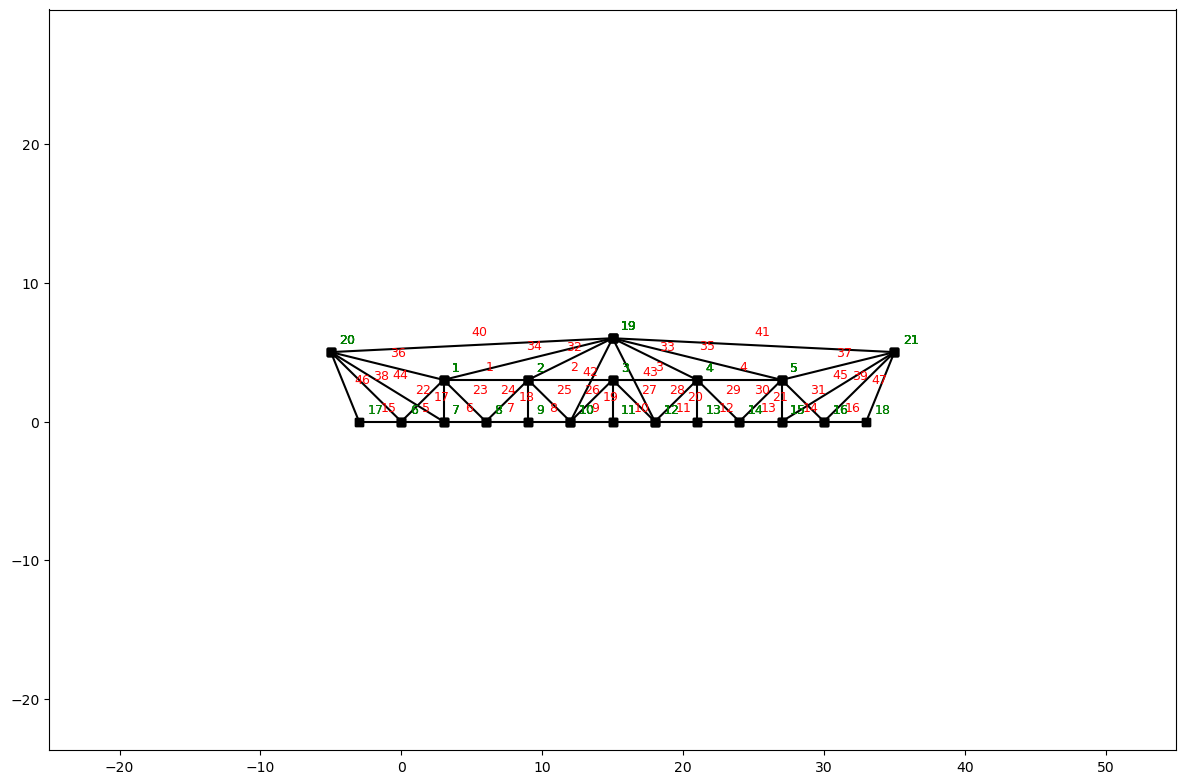

In [43]:
my_truss_geometry = create_my_truss(display = True)

In [44]:
def load_my_truss(truss, applied_load, display = False):
    #The hinge
    truss.add_support_hinged(17)
    truss.add_support_hinged(18)
    truss.add_support_hinged(9)
    truss.add_support_hinged(13)
    #Applied Load
    truss.point_load(19, Fy = -applied_load)
    for member_id in range(1, truss.id_last_element + 1):
        truss.q_load(-weight_per_metre, member_id, direction = 'y')
    
    if display == True:
        truss.show_structure()
    
    return truss

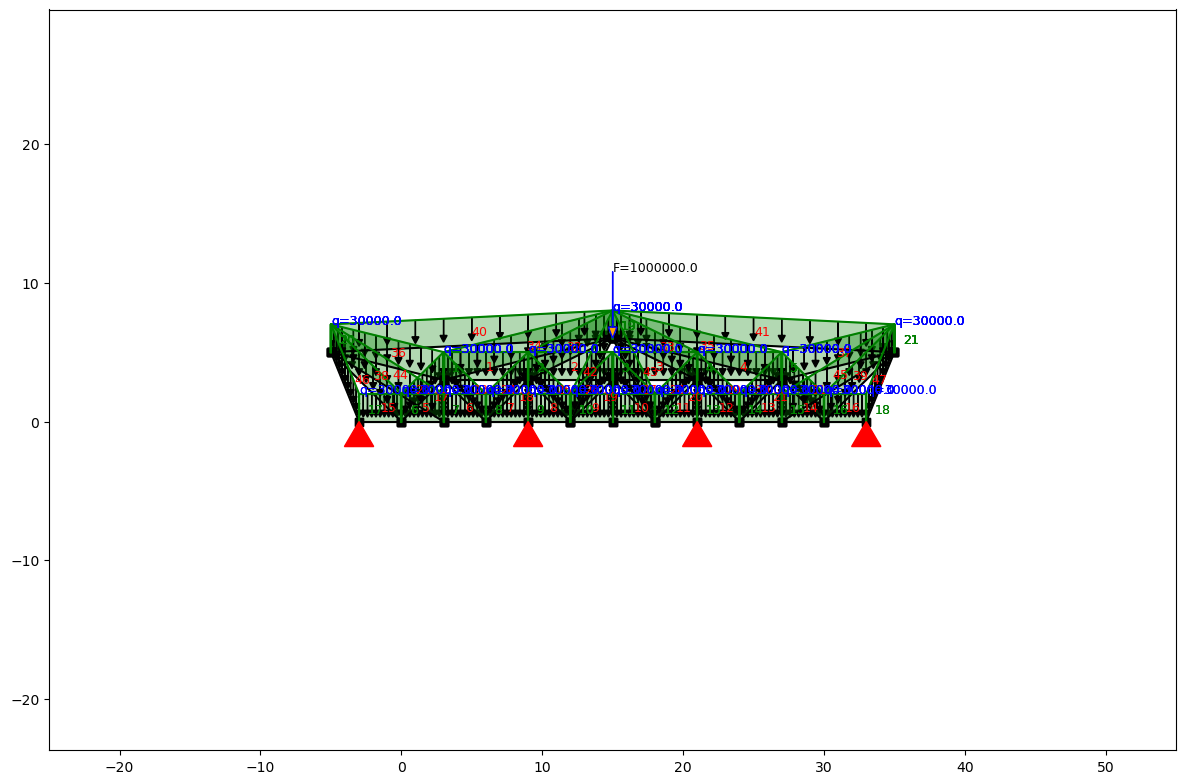

In [45]:
my_truss_loaded = load_my_truss(my_truss_geometry, 1e6, display = True)

In [46]:
member_forces, member_lengths, node_displacements = solve_truss(my_truss_geometry, display = True)

Member forces:
[-5067, 273643, 273643, -5067, 244208, 627297, -346420, -932171, 932171, 932171, -932171, -346420, 627297, 244208, -525085, -525085, 82079, -2746480, 180000, -2746480, 82079, -315333, -489882, 887161, 1837726, -299558, -299558, 1837726, 887161, -489882, -315333, -1018095, -1018095, 60878, 60878, -86569, -86569, 802612, 802612, -174716, -174716, -699452, -699452, 526756, 526756, -1527143, -1527143] 

Member lengths:
[6.0, 6.0, 6.0, 6.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.242640495300293, 4.242640495300293, 4.242640495300293, 4.242640495300293, 4.242640495300293, 4.242640495300293, 4.242640495300293, 4.242640495300293, 4.242640495300293, 4.242640495300293, 6.7082037925720215, 6.7082037925720215, 12.369317054748535, 12.369317054748535, 8.246211051940918, 8.246211051940918, 7.071067810058594, 7.071067810058594, 20.02498435974121, 20.02498435974121, 6.7082037925720215, 6.7082037925720215, 9.433980941772461, 9.433980941772461

In [47]:
#This is to test if i had any failure before running the failure function
forces, lengths, y_displacements = solve_truss(example_truss_loaded)
is_truss_safe(forces, lengths, y_displacements)

'safe'

In [49]:
# Call functions from part 2 and 3 to test out your truss.
failure_load(my_truss_loaded)
# It was very safe
# It needed more than 2 million N for the truss to reach failure

2370000